<a href="https://colab.research.google.com/github/EBOrlando/PowerBI-DataScience/blob/master/Case_Magnetis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Teste vaga Data Analyst - Magnetis**

Para realizar as analises do funil de conversão utilizaremos a linguagem python.
O objetivo da analise é entender um pouco melhor nosso público e sua jornada.

### **Setup**
Importando os pacotes que utilizaremos ao longa da analise e carregando os dados do arquivo csv

In [0]:
#@title Import dos pacotes
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import chart_studio.plotly as plotly
import plotly.graph_objs as go
import warnings
from collections import defaultdict
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set(style="whitegrid", palette="pastel")
sns.set(rc={'figure.figsize':(18,8)})

In [5]:
#@title Carregando os dados originais
df_original = pd.read_csv('navegacao_usuarios.csv')
df_original.head()

#faremos um cópia do dataframe original e trabalharemos com ela
df = df_original.copy()
df.columns = ['customer_id', 'source', 'device', 'page', 'valor']
df = df.sort_values(['customer_id', 'page'])
#adicionando uma coluna que indica a conversão
df['conversion'] = np.where(df.page == '4 - Cadastro', 1, 0)
df.head(10)

,customer_id,source,device,page,valor,conversion
0,1,Paid Search,desktop,1 - Homepage,NaN,0
1,2,Paid Search,desktop,1 - Homepage,NaN,0
3,3,Paid Search,desktop,1 - Homepage,2000.0,0
5,3,Paid Search,desktop,2 - Questionário,2000.0,0
4,3,Paid Search,desktop,3 - Plano de Investimentos,2000.0,0
2,3,Paid Search,desktop,4 - Cadastro,2000.0,1
6,4,Paid Search,desktop,1 - Homepage,NaN,0
7,5,Paid Search,desktop,1 - Homepage,NaN,0
8,6,Paid Search,desktop,1 - Homepage,NaN,0
9,7,Paid Search,desktop,1 - Homepage,NaN,0


In [0]:
from google.colab import drive
drive.mount('/content/drive')

###**Uma breve validação** 
Para analise que eu gostaria de fazer é fundamental que as jornadas estejam deduplicas, ou seja, que um mesmo usuário não passe duas vezes pela mesma página. 
Vamos checar isso, vendo se o número distintos de usuário por página é igual ao número linhas por página.

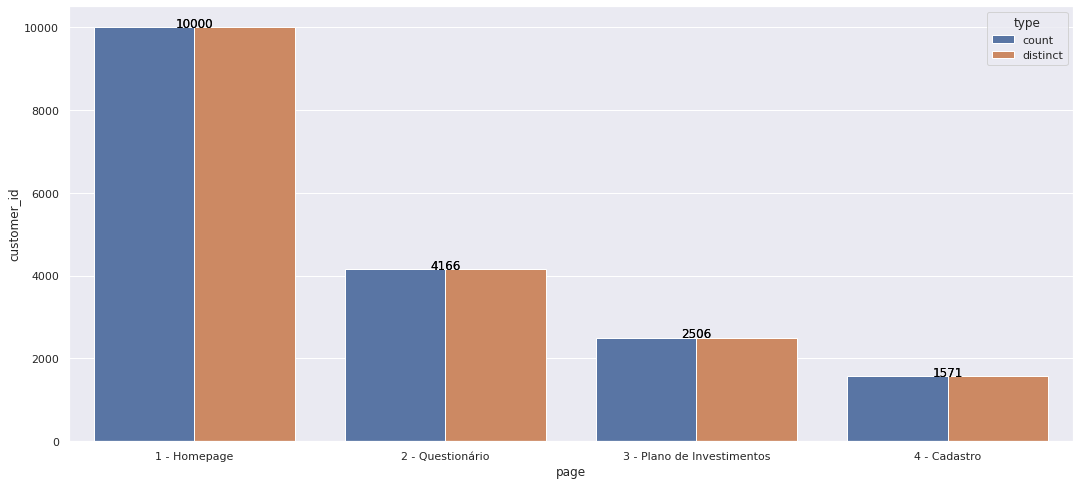

In [31]:
#@title Comparativo Usuários Únicos x Count
count_page = count_page.reset_index()
count_page['type'] = 'count'

dist_user_page = df.groupby(by="page")['customer_id'].nunique()
dist_user_page = dist_user_page.reset_index()
dist_user_page['type'] = 'distinct'

compare = pd.concat([count_page, dist_user_page], axis=0)
g = sns.barplot(x='page', y='customer_id', hue = 'type', data=compare)

for index, row in compare.iterrows():
    g.text(row.name, row.customer_id, round(row.customer_id,2), color='black', ha="center")

### **Analise do funil**
Com a validação feita podemos seguir com a analise do funil, aproveitando para acrescentar a quebra por source medium.

In [29]:
#@title Funil de conversão por source

# Com nossa validação podemos passar para uma analise de funil
steps = ['1 - Homepage', '2 - Questionário', '3 - Plano de Investimentos', '4 - Cadastro']
events = df.groupby(by=['page', 'source'])['customer_id'].count().reset_index()

def group_funnel_dfs(events, steps, col):
    
    dict_ = {}
    for s in events[col].unique():
        df_dict = events[events[col]==s].reset_index(drop=True)
        
        df_dict['pct'] = (100 - 100 * abs(df_dict['customer_id'].pct_change()).fillna(0)).astype(int)
        df_dict['val-1'] = df_dict['customer_id'].shift(1)
        df_dict['pct_from_first'] = (df_dict['customer_id'] / df_dict.iloc[0,2] * 100).fillna(0).astype(int)

        dict_[s] = df_dict

    return dict_

def plot_stacked_funnel(df, steps, col=None):

    data = []

    # if col is provided, create a funnel_df for each entry in the "col"
    if col:
        # generate dict of funnel dataframes
        dict_ = group_funnel_dfs(df, steps, col)
        title = 'Funil de conversão por'.format(col)
    
    else:
        funnel_df = df
        dict_ = {'Total': funnel_df}
        title = 'Funil de conversão'

    for t in dict_.keys():
        trace = go.Funnel(
            name=t,
            y=dict_[t].page.values,
            x=dict_[t].customer_id.values,
            textinfo="value+percent previous"
        )
        data.append(trace)

    layout = go.Layout(margin={"l": 180, "r": 0, "t": 30, "b": 0, "pad": 0},
                       funnelmode="stack",
                       showlegend=True,
                       hovermode='closest',
                       title='Funil de conversão por {}'.format(col),
                       legend=dict(orientation="v",
                                   bgcolor='#E2E2E2',
                                   xanchor='left',
                                   font=dict(
                                       size=12)
                                   )
                       )

    return go.Figure(data, layout)

plot_stacked_funnel(events, steps, col='source')

### **Device e source_medium**
Podemos também tentar entender o perfil de investimento do público com quebra por device e source medium.
Aqui não levamos em consideração investimentos simulados acima de R$250.000,00 e valores não informados para evitar outliers.

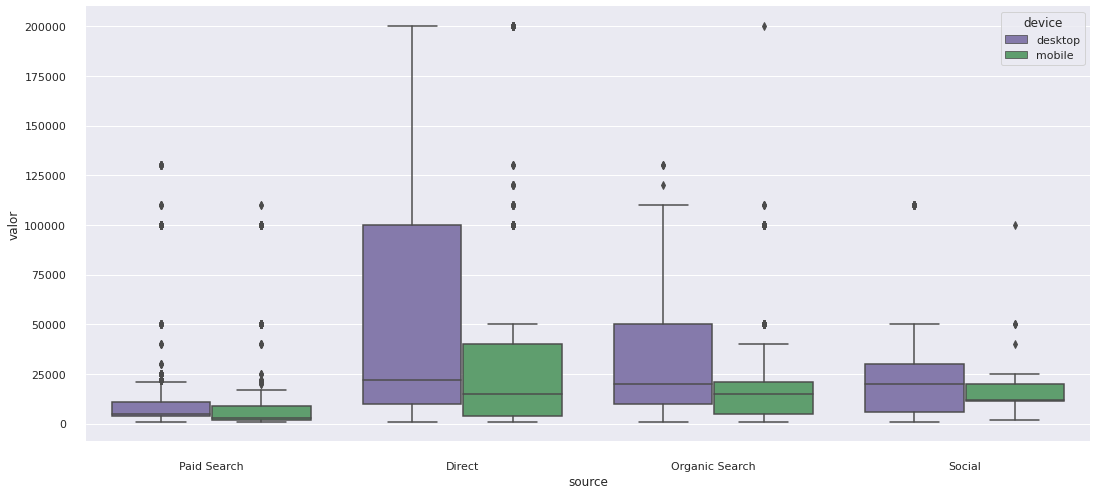

In [30]:
#@title Variação do investimento por device e source
sns.boxplot(x="source", y="valor",
            hue="device", palette=["m", "g"],
            data=df[df['valor']<= 250000]
            )
sns.despine(offset=10, trim=True)

### **Taxa de conversão por tipo de usuário: desktop x mobile**

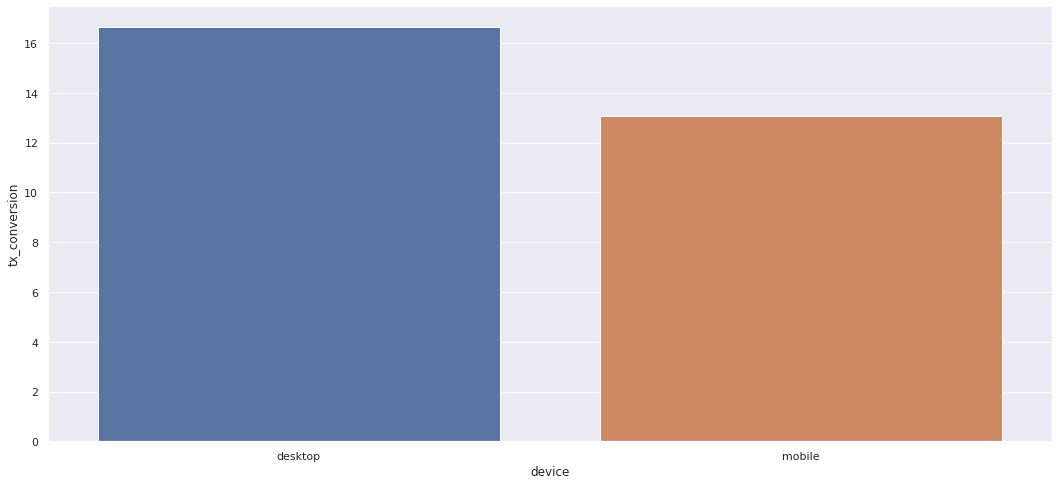

In [59]:
#@title Comparativo da taxa de conversão entre devices
conversoes = pd.DataFrame(df.groupby('device')['conversion'].sum()).reset_index()
unicos = pd.DataFrame(df.groupby('device')['customer_id'].nunique()).reset_index()
conv_device = pd.merge(conversoes, unicos,how='left', on='device')
conv_device['tx_conversion'] = (conv_device['conversion']/conv_device['customer_id'])*100

sns.barplot(x='device', y='tx_conversion', data=conv_device)

### **Modelo de atribuição - Last Click**
O modelo de atribuição mais clássico é chamado de last click, e leva em consideração o último source medium para atribuir a conversão.

Vamos dar uma olhada nos canais que mais impactam a conversão


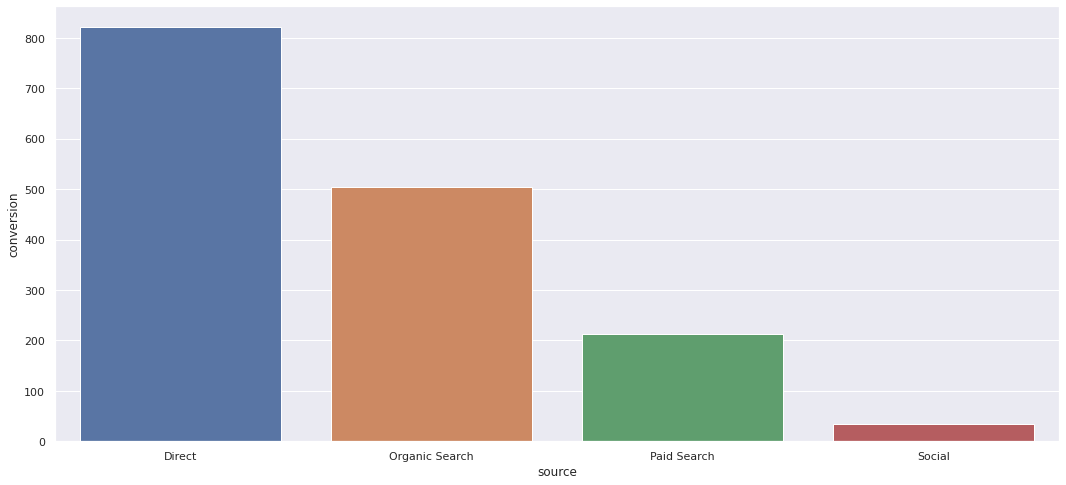

In [19]:
#@title Last Click
last_click = df[df['page']=='4 - Cadastro']
last_click = df.groupby(by=['source'])['conversion'].sum().reset_index()
last_click = last_click.sort_values('source').reset_index(drop=True)
last_click['type'] = 'last'

sns.barplot(x="source", y="conversion", data = last_click)
for index, row in last_click.iterrows():
    g.text(row.name, row.conversion, round(row.conversion,0), color='black', ha="center")

### **Markov - Atribuição Multicanais**
Apesar de interessante o modelo de atribuição last click pode esconder algumas nuances, pois desconsidera a existência de pontos de contato através de outros canais anteriormente.

Uma abordagem para atribuição multicanais é utilizando Cadeias de Markov.

In [23]:
#@title Criando os paths (jornadas pelos canais)
df_paths = df.groupby(by="customer_id")['source'].aggregate(lambda x: x.unique().tolist()).reset_index()
df_last_interaction = df.drop_duplicates('customer_id', keep='last')[['customer_id', 'conversion']]
df_paths = pd.merge(df_paths, df_last_interaction, how='left', on='customer_id')
df_paths['path'] = np.where(df_paths['conversion'] == 0,
                                ['Start, '] + df_paths['source'].apply(', '.join) + [', Null'],
                                ['Start, '] + df_paths['source'].apply(', '.join) + [', Conversion'])
df_paths['path'] = df_paths['path'].str.split(', ')
df_paths.head()

,customer_id,source,conversion,path
0,1,[Paid Search],0,"[Start, Paid Search, Null]"
1,2,[Paid Search],0,"[Start, Paid Search, Null]"
2,3,[Paid Search],1,"[Start, Paid Search, Conversion]"
3,4,[Paid Search],0,"[Start, Paid Search, Null]"
4,5,[Paid Search],0,"[Start, Paid Search, Null]"


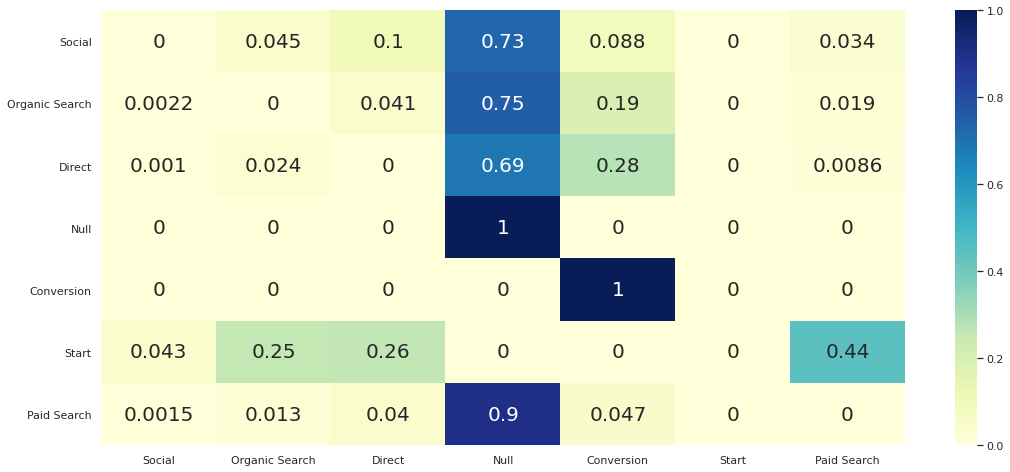

In [24]:
#@title Criando os estados de transição, as probabilidades de transição e por fim a matriz de transição
list_of_paths = df_paths['path']
total_conversions = sum(path.count('Conversion') for path in df_paths['path'].tolist())
base_conversion_rate = total_conversions / len(list_of_paths)

def transition_states(list_of_paths):
    list_of_unique_channels = set(x for element in list_of_paths for x in element)
    transition_states = {x + '>' + y: 0 for x in list_of_unique_channels for y in list_of_unique_channels}

    for possible_state in list_of_unique_channels:
        if possible_state not in ['Conversion', 'Null']:
            for user_path in list_of_paths:
                if possible_state in user_path:
                    indices = [i for i, s in enumerate(user_path) if possible_state in s]
                    for col in indices:
                        transition_states[user_path[col] + '>' + user_path[col + 1]] += 1

    return transition_states


trans_states = transition_states(list_of_paths)

def transition_prob(trans_dict):
    list_of_unique_channels = set(x for element in list_of_paths for x in element)
    trans_prob = defaultdict(dict)
    for state in list_of_unique_channels:
        if state not in ['Conversion', 'Null']:
            counter = 0
            index = [i for i, s in enumerate(trans_dict) if state + '>' in s]
            for col in index:
                if trans_dict[list(trans_dict)[col]] > 0:
                    counter += trans_dict[list(trans_dict)[col]]
            for col in index:
                if trans_dict[list(trans_dict)[col]] > 0:
                    state_prob = float((trans_dict[list(trans_dict)[col]])) / float(counter)
                    trans_prob[list(trans_dict)[col]] = state_prob

    return trans_prob


trans_prob = transition_prob(trans_states)

def transition_matrix(list_of_paths, transition_probabilities):
    trans_matrix = pd.DataFrame()
    list_of_unique_channels = set(x for element in list_of_paths for x in element)

    for channel in list_of_unique_channels:
        trans_matrix[channel] = 0.00
        trans_matrix.loc[channel] = 0.00
        trans_matrix.loc[channel][channel] = 1.0 if channel in ['Conversion', 'Null'] else 0.0

    for key, value in transition_probabilities.items():
        origin, destination = key.split('>')
        trans_matrix.at[origin, destination] = value

    return trans_matrix


trans_matrix = transition_matrix(list_of_paths, trans_prob)

sns.heatmap(trans_matrix,cmap="YlGnBu", annot=True, annot_kws={"size": 20})

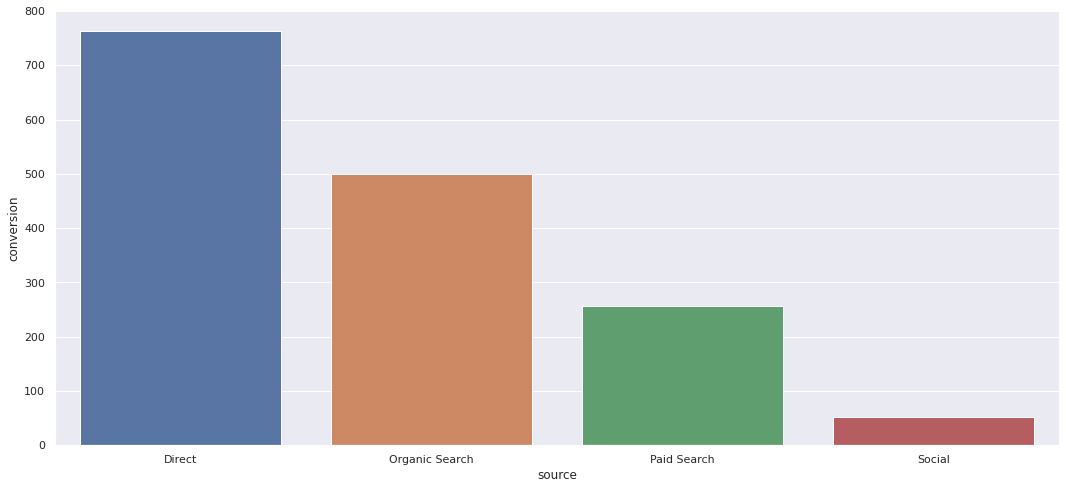

In [25]:
#@title Por fim é possível agora percorrer cada simulando o que aconteceria se ele não existisse e então calcular o impacto de cada canal na conversão
def removal_effects(df, conversion_rate):
    removal_effects_dict = {}
    channels = [channel for channel in df.columns if channel not in ['Start',
                                                                     'Null',
                                                                     'Conversion']]
    for channel in channels:
        removal_df = df.drop(channel, axis=1).drop(channel, axis=0)
        for column in removal_df.columns:
            row_sum = np.sum(list(removal_df.loc[column]))
            null_pct = float(1) - row_sum
            if null_pct != 0:
                removal_df.loc[column]['Null'] = null_pct
            removal_df.loc['Null']['Null'] = 1.0

        removal_to_conv = removal_df[
            ['Null', 'Conversion']].drop(['Null', 'Conversion'], axis=0)
        removal_to_non_conv = removal_df.drop(
            ['Null', 'Conversion'], axis=1).drop(['Null', 'Conversion'], axis=0)

        removal_inv_diff = np.linalg.inv(
            np.identity(
                len(removal_to_non_conv.columns)) - np.asarray(removal_to_non_conv))
        removal_dot_prod = np.dot(removal_inv_diff, np.asarray(removal_to_conv))
        removal_cvr = pd.DataFrame(removal_dot_prod,
                                   index=removal_to_conv.index)[[1]].loc['Start'].values[0]
        removal_effect = 1 - removal_cvr / conversion_rate
        removal_effects_dict[channel] = removal_effect

    return removal_effects_dict


removal_effects_dict = removal_effects(trans_matrix, base_conversion_rate)

def markov_chain_allocations(removal_effects, total_conversions):
    re_sum = np.sum(list(removal_effects.values()))

    return {k: (v / re_sum) * total_conversions for k, v in removal_effects.items()}


attributions = markov_chain_allocations(removal_effects_dict, total_conversions)

multi = pd.DataFrame.from_dict(attributions, orient='index')
multi = multi.reset_index()
multi.columns = ['source', 'conversion']
multi = multi.sort_values('source').reset_index(drop=True)
multi['type'] = 'multi'

g = sns.barplot(x='source', y='conversion', data=multi)


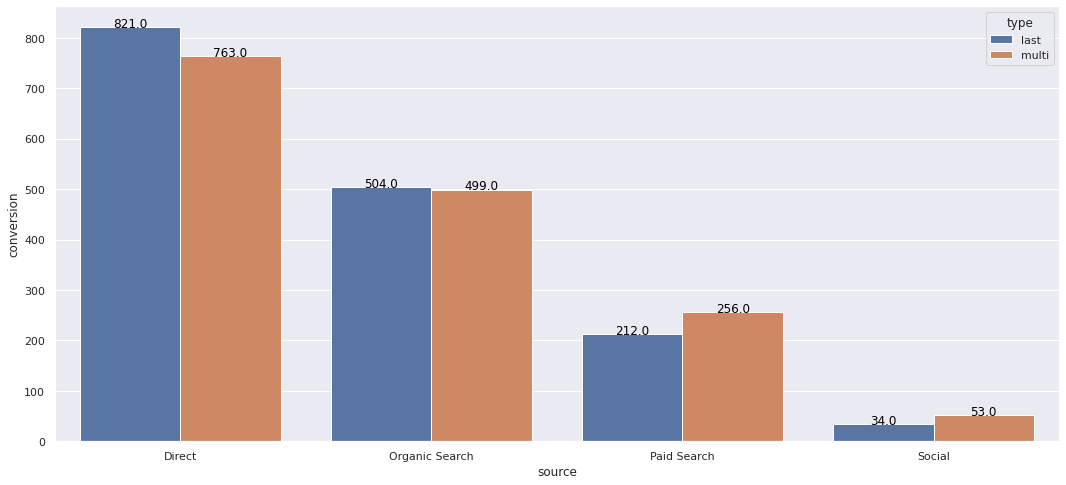

In [26]:
#@title Podemos então fazer uma comparação Last Click x Markov
testando = pd.concat([last_click, multi], axis=0)
g = sns.barplot(x='source', y='conversion', hue = 'type', data=testando)

for index, row in testando[testando['type']=='last'].iterrows():
    g.text(row.name-.20, row.conversion, round(row.conversion,0), color='black', ha="center")
for index, row in testando[testando['type']=='multi'].iterrows():
    g.text(row.name+.20, row.conversion, round(row.conversion,0), color='black', ha="center")
